In [2]:
### Import
from pycoingecko import CoinGeckoAPI
from datetime import datetime
from pprint import pprint
import numpy as np
import pandas as pd
import math
import pulp
import matplotlib.pyplot as plt


client = CoinGeckoAPI()

In [3]:
### Configuration
from_date_str = "01-01-2019"
to_date_str = "01-11-2020"

from_date = datetime.strptime(from_date_str, '%d-%m-%Y')
to_date = datetime.strptime(to_date_str, '%d-%m-%Y')
# SNX Missing

coins_list = [
    'bitcoin', 'ethereum', 'tezos', 'binancecoin', 
    'litecoin', 'chainlink', 'polkadot', 'eos', 'stellar', 
    'aave', 'uniswap', 'maker', 'yearn-finance', 'compound-governance-token', 'algorand', 
    'icon', 'ampleforth', 'kyber-network', 'enjincoin', 'elrond-erd-2', 'solana','balancer', 'cosmos', 
    'ftx-token', '0x', 'algorand'
]

coins_list = [
    'bitcoin', 'ethereum', 'binancecoin', 
    'litecoin', 'chainlink', 'eos', 'stellar', 
    'aave', 'uniswap', 'maker', 'yearn-finance', 'compound-governance-token', 'algorand', 
    'kyber-network', 'ftx-token', '0x',# 'algorand'
]

coins_list = [
    'bitcoin', 'ethereum', 'binancecoin', 
    'chainlink', 'eos',
]
a = client.get_coin_by_id('ethereum')
CONFIG_DICT = {
    "risk_free_rate_of_return" : 2,
    "risk_condition": 2,
    "completness_condition": 100,
}

In [4]:
### Stats Data
to_data = {}

for coin in coins_list:
    _ = client.get_coin_by_id(coin)
    to_data[coin] = {
        "1d": _['market_data']["price_change_percentage_24h"],
        "7d": _['market_data']["price_change_percentage_7d"],
        "30d": _['market_data']["price_change_percentage_30d"],
        "1y": _['market_data']['price_change_percentage_1y'],
        "alexa_rank": _['public_interest_stats']['alexa_rank'],
        "symbol": _["symbol"]
    }

#to_data

In [5]:
### Historical Data
to_csv = {}
list_csv = []
tickers = {}
for coin in coins_list:
    _ = client.get_coin_market_chart_range_by_id(coin, 'usd', datetime.timestamp(from_date), datetime.timestamp(to_date))

    prices_list = _['prices']
    total_volumes_list = _['total_volumes']
    market_caps_list = _['market_caps']
    
    flat_timestamp = [el[0] for el in prices_list]
    flat_price = [el[1] for el in prices_list]
    flat_total_volume = [el[1] for el in total_volumes_list]
    flat_market_cap = [el[1] for el in market_caps_list]

    tmp = []

    for i in range(len(flat_timestamp)):
        _ = {}
        #_["timestamp"] = datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S')
        #_["price"] = flat_price[i]
        #_["total_volume"] = flat_total_volume[i]
        #_["market_cap"] = flat_market_cap[i]
        
        #_[datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S')] = {"price": flat_price[i], "total_volume": flat_total_volume[i], "market_cap": flat_market_cap[i]}
        tmp.append({
            #"date": datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S'),
            "date": pd.Timestamp(flat_timestamp[i], unit='ms', tz="UTC"),
            "price": flat_price[i], 
            "total_volume": flat_total_volume[i], 
            "market_cap": flat_market_cap[i],
            "coin_name": coin,
        })
    df = pd.DataFrame(tmp, columns=("date", "price", "total_volume","market_cap", "coin_name"))
    # test = pd.MultiIndex.from_tuples(to_csv, names=["first", "second", "third", "fourth", "fifth"])
    #df = pd.DataFrame(list_csv, columns=("timestamp", "price", "total_volume","market_cap", "coin_name")) 
    df.set_index(["date"])
    tickers[coin] = df
    #pprint(tmp)
    #to_csv.append(tmp)
    #list_csv.append(tmp)
    #to_csv.update(tmp)

pprint(tickers["bitcoin"])
#pprint(list_csv)
#test = [timestamp, prices_list, total_volumes_list, market_caps_list]
#test = zip(timestamp, prices_list[1], total_volumes_list[1], market_caps_list[1])
#test = zip(timestamp, a, b, c)
#csv_dict = {"timestamp": timestamp, "prices": prices_list, "total_volumes": total_volumes_list, "market_caps": market_caps_list}


                         date         price  total_volume    market_cap  \
0   2019-01-01 00:00:00+00:00   3692.531566  2.991428e+09  6.442264e+10   
1   2019-01-02 00:00:00+00:00   3794.264254  2.689878e+09  6.618845e+10   
2   2019-01-03 00:00:00+00:00   3872.172184  3.263469e+09  6.764330e+10   
3   2019-01-04 00:00:00+00:00   3776.525808  2.261200e+09  6.592229e+10   
4   2019-01-05 00:00:00+00:00   3815.268080  2.950055e+09  6.665077e+10   
..                        ...           ...           ...           ...   
665 2020-10-27 00:00:00+00:00  13060.792212  2.150762e+10  2.421412e+11   
666 2020-10-28 00:00:00+00:00  13655.185416  2.391851e+10  2.530049e+11   
667 2020-10-29 00:00:00+00:00  13282.999348  2.682586e+10  2.456619e+11   
668 2020-10-30 00:00:00+00:00  13441.878496  2.286084e+10  2.495455e+11   
669 2020-10-31 00:00:00+00:00  13537.174272  2.348276e+10  2.508454e+11   

    coin_name  
0     bitcoin  
1     bitcoin  
2     bitcoin  
3     bitcoin  
4     bitcoin  
.. 

In [6]:
### Calcul des Perfs/Volatilité Weekly/Daily

for coin in coins_list:
    _ = tickers[coin]
    _["daily_perfs"] = _["price"].pct_change()
    _["cum_daily_perfs"] = _["daily_perfs"].cumsum()
    #print(_.loc[(_["date"].dt.day_name() == 'Monday')]['price'].pct_change())
    _["weekly_perfs"] = _.loc[(_["date"].dt.day_name() == 'Monday')]['price'].pct_change()
    _["cum_weekly_perfs"] = _["weekly_perfs"].cumsum()
    #_["weekly_perfs"] = _.lo
    #print(_)
    #print(_["weekly_perfs"])
    #_["weekly_perfs"] = _["price"].pct_change(freq='M')

pd.set_option("display.max_rows", 10, "display.max_columns", 30)
print(tickers["bitcoin"])

print(tickers["bitcoin"].info())
tickers["bitcoin"].describe()

                         date         price  total_volume    market_cap  \
0   2019-01-01 00:00:00+00:00   3692.531566  2.991428e+09  6.442264e+10   
1   2019-01-02 00:00:00+00:00   3794.264254  2.689878e+09  6.618845e+10   
2   2019-01-03 00:00:00+00:00   3872.172184  3.263469e+09  6.764330e+10   
3   2019-01-04 00:00:00+00:00   3776.525808  2.261200e+09  6.592229e+10   
4   2019-01-05 00:00:00+00:00   3815.268080  2.950055e+09  6.665077e+10   
..                        ...           ...           ...           ...   
665 2020-10-27 00:00:00+00:00  13060.792212  2.150762e+10  2.421412e+11   
666 2020-10-28 00:00:00+00:00  13655.185416  2.391851e+10  2.530049e+11   
667 2020-10-29 00:00:00+00:00  13282.999348  2.682586e+10  2.456619e+11   
668 2020-10-30 00:00:00+00:00  13441.878496  2.286084e+10  2.495455e+11   
669 2020-10-31 00:00:00+00:00  13537.174272  2.348276e+10  2.508454e+11   

    coin_name  daily_perfs  cum_daily_perfs  weekly_perfs  cum_weekly_perfs  
0     bitcoin        

,price,total_volume,market_cap,daily_perfs,cum_daily_perfs,weekly_perfs,cum_weekly_perfs
count,670.000000,6.700000e+02,6.700000e+02,669.000000,669.000000,94.000000,94.000000
mean,8307.598973,2.504943e+10,1.505277e+11,0.002626,0.990202,0.016673,0.884890
std,2501.094158,1.320903e+10,4.656769e+10,0.036335,0.473334,0.089535,0.446416
min,3394.014653,2.261200e+09,5.948240e+10,-0.351903,-0.073550,-0.328729,-0.140537
25%,6956.276880,1.801147e+10,1.263745e+11,-0.011329,0.874340,-0.017348,0.788784
50%,8801.764171,2.285256e+10,1.599758e+11,0.001701,1.109126,0.011387,1.000918
75%,10156.818394,3.101277e+10,1.830306e+11,0.016034,1.328963,0.064010,1.174486
max,13655.185416,8.140669e+10,2.530049e+11,0.172661,1.764811,0.261594,1.567216


In [7]:
### Covariance
import pypfopt
from pypfopt import (
    EfficientFrontier, HRPOpt,  objective_functions, 
    CLA, risk_models, expected_returns, plotting
)
    

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

#Test avec les différent join pour les ticker soù les dimensions de prix ne matchent pas
# min_periods dans la covar pour enlever si il n'y a pas assez de data
price_matrix = pd.concat([tickers[coin]["price"].rename(coin) for coin in coins_list], axis=1, join='inner')
#price_matrix.cov()
#price_matrix.reset_index(drop=True, inplace=True)
# pour rajouter les date au dataframe de prix
#date_price_matrix = pd.concat([tickers[coin]["date"], price_matrix], axis=1, join='inner')
#df = date_price_matrix
df = price_matrix
print(price_matrix)

          bitcoin    ethereum  binancecoin  chainlink       eos
0     3692.531566  131.458725     6.082209   0.295491  2.523546
1     3794.264254  138.144802     5.987467   0.306331  2.616709
2     3872.172184  152.860453     6.057147   0.331284  2.833973
3     3776.525808  146.730599     5.800076   0.357958  2.630978
4     3815.268080  153.056567     5.967081   0.427056  2.686171
..            ...         ...          ...        ...       ...
665  13060.792212  393.382908    31.111160  11.739328  2.631203
666  13655.185416  403.529838    31.580052  11.972448  2.672156
667  13282.999348  388.877340    30.383165  11.457146  2.656176
668  13441.878496  386.446013    29.821939  11.270950  2.634729
669  13537.174272  382.900771    28.497481  11.074030  2.505432

[670 rows x 5 columns]


OrderedDict([('bitcoin', -0.28688), ('ethereum', 0.38264), ('binancecoin', 0.16531), ('chainlink', 0.36037), ('eos', 0.37855)])
Expected annual return: 112.6%
Annual volatility: 81.5%
Sharpe Ratio: 1.36
Discrete allocation: {'ethereum': 28, 'binancecoin': 161, 'chainlink': 903, 'eos': 4188}
Funds remaining: $10740.68


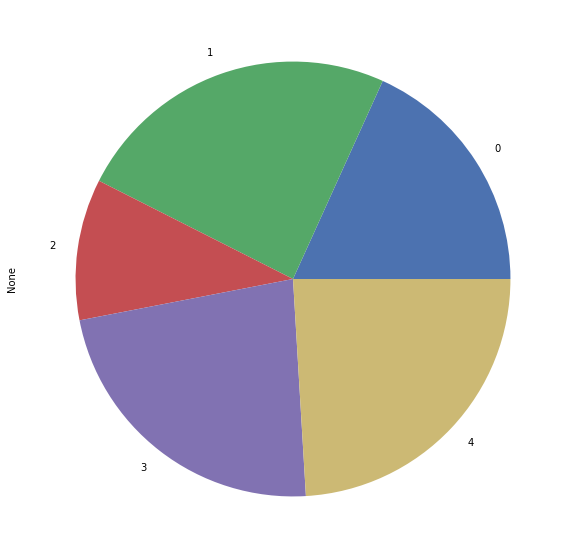

In [18]:
### NORMAL EMA/MEAN HISTORICAL VALUE

#mu = expected_returns.mean_historical_return(df)
#mu = expected_returns.ema_historical_return(df)
mu = expected_returns.capm_return(df)
#mu = expected_returns.returns_from_prices(df)
#mu = expected_returns.prices_from_returns(df)

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)



# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers)] * len(tickers))

ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1), gamma=1)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001) # 1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is gamma=1

#ef.min_volatility()
#ef.max_sharpe()
ef.max_quadratic_utility()
#ef.min_efficient_risk(0.5)
#ef.min_efficient_return(0.5)


cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10))

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=35802, short_ratio=0.3)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

ef: <pypfopt.hierarchical_portfolio.HRPOpt object at 0x7fcbb00ba070>
cleaned weight: OrderedDict([('bitcoin', 0.0), ('ethereum', 0.00023), ('binancecoin', 0.0268), ('chainlink', 0.10686), ('eos', 0.86611)])
Expected annual return: 101419.4%
Annual volatility: 1922.6%
Sharpe Ratio: 52.75
Discrete allocation: {'binancecoin': 34, 'chainlink': 345, 'eos': 12377}
Funds remaining: $2.81


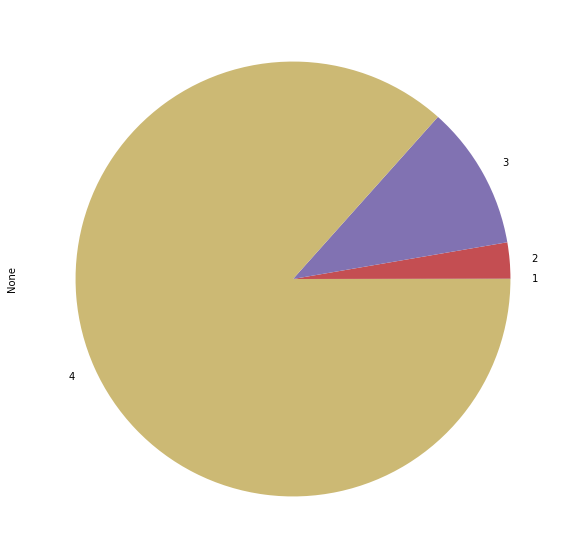

In [19]:
### HRPOPT TECHNIQUE

# En HRP on ne fait pas d'estimation des perfs 
mu = df

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

ef = HRPOpt(mu, S)

#import scipy.cluster.hierarchy as sch
#print(sch._LINKAGE_METHODS)
raw_weights = ef.optimize('single')

print(f"ef: {ef}")
#print(f"raw_weights: {raw_weights}")
cleaned_weights = ef.clean_weights()
print(f"cleaned weight: {cleaned_weights}")

ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10))

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=35802, short_ratio=0.3)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

OrderedDict([('bitcoin', 1.0), ('ethereum', -0.21546), ('binancecoin', 0.22286), ('chainlink', 0.04713), ('eos', -0.05453)])
Expected annual return: 69.5%
Annual volatility: 56.2%
Sharpe Ratio: 1.20
Discrete allocation: {'bitcoin': 2, 'binancecoin': 221, 'chainlink': 120, 'ethereum': -22, 'eos': -866}
Funds remaining: $1247.90


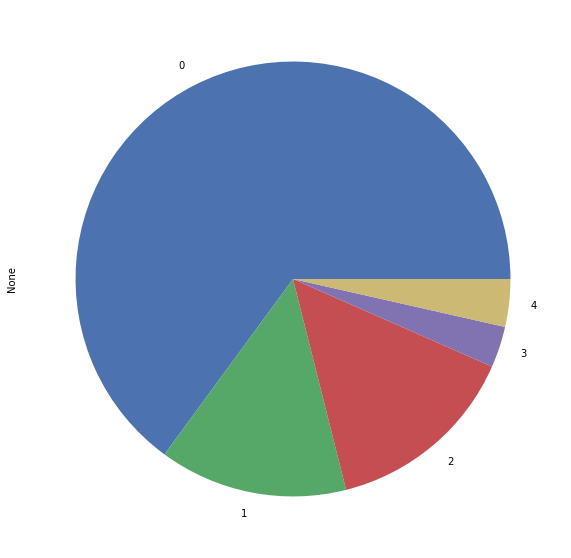

In [29]:
### CLA TECHNIQUE

#mu = expected_returns.mean_historical_return(df)
#mu = expected_returns.ema_historical_return(df)
mu = expected_returns.capm_return(df)
#mu = expected_returns.returns_from_prices(df)
#mu = expected_returns.prices_from_returns(df)

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)



# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers)] * len(tickers))

ef = CLA(mu, S, weight_bounds=(-1, 1))
#ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001) # 1% broker commission
#ef.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is gamma=1

ef.min_volatility()
#ef.max_sharpe()


#ef.efficient_frontier()



cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10))

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=35802, short_ratio=0.3)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

bitcoin        0.197887
ethereum       0.222379
binancecoin    0.111000
chainlink      0.065410
eos            0.200622
dtype: float64
                Prior  Posterior  Views
bitcoin      0.685188   0.197887   0.10
ethereum     0.476660   0.222379   0.30
binancecoin  0.473680   0.111000   0.05
chainlink    0.529915   0.065410   0.05
eos          0.193434   0.200622   0.20


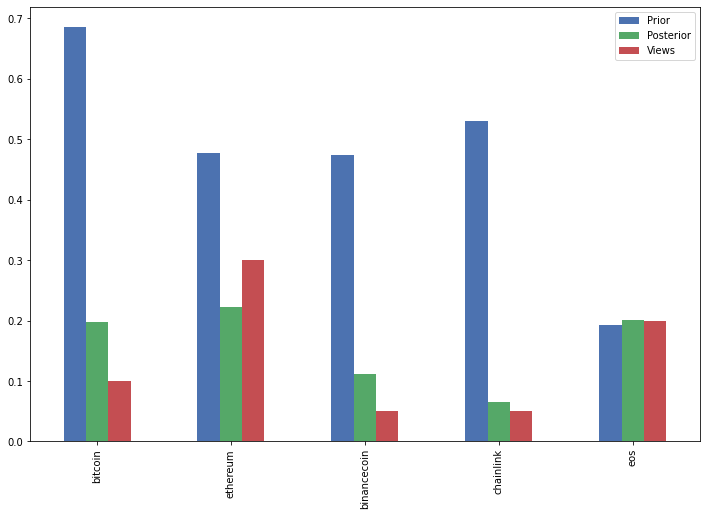

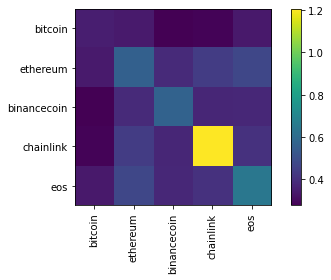

ValueError: Data must be 1-dimensional

In [8]:
# Black-Litterman

from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()
#print(S)
delta = black_litterman.market_implied_risk_aversion(df) # Je trouve le Delta elevé
#print(delta)
#plotting.plot_covariance(S, plot_correlation=True);

#print(tickers["bitcoin"]["market_cap"].iloc[-1])
mcaps = {i:tickers[i]["market_cap"].iloc[-1] for i in coins_list}
#print(mcaps)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
#print(market_prior)

#market_prior.plot.barh(figsize=(10,5));

# Contruction de la view pour estimer

# Relative View
"""Each view has a corresponding row in the picking matrix (the order matters)
Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe.
Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns. 
The numbers in each row should sum up to 0."""

Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1) # Absolute
P = np.array( # Relative
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)
# Absolute View
viewdict = {
    "bitcoin": 0.10,
    "ethereum": 0.30,
    "binancecoin": 0.05,
    "chainlink": 0.05,
    "eos": 0.20,
}

# Optionnal - Arbitrary confidences
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek", tau=0.05)
# Optionnal - Standar deviation confidences

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
]
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

#print(variances)
omega = np.diag(variances)

# We are using the shortcut to automatically compute market-implied prior
# pi = market_prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, absolute_views=viewdict, omega=omega, tau=0.05)
# argument de BlackLuttermanModel (cov_matrix, pi=None, absolute_views=None, Q=None, P=None, omega=None, view_confidences=None, tau=0.05, risk_aversion=1)

#fig, ax = plt.subplots(figsize=(7,7))
#im = ax.imshow(bl.omega)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(bl.tickers)))
#ax.set_yticks(np.arange(len(bl.tickers)))

#ax.set_xticklabels(bl.tickers)
#ax.set_yticklabels(bl.tickers)
#plt.show()
#np.diag(bl.omega)

# Posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
print(rets_df)

rets_df.plot.bar(figsize=(12,8));
# Posterior covariance estimate
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

from pypfopt import EfficientFrontier, objective_functions

## 2 Facon d'avoir les poids

# USE return-implied weights
bl.bl_weights(delta)
weights = bl.clean_weights()


# Ou autrement
#ef = EfficientFrontier(ret_bl, S_bl)
#ef.add_objective(objective_functions.L2_reg)
#ef.max_sharpe()
#bl.bl_weights(delta)
#weights = ef.clean_weights()


pd.Series(weights).plot.pie(figsize=(10,10));


from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc